## IMT2118 - Taller 3: Incendios Forestales en Chile.

### 1. Aspectos generales.

- **Fecha de entrega:** 22 de octubre 2020, 23:59.

- **Formato de entrega:** carpeta comprimida (.zip) incluyendo Jupyter Notebook con el desarrollo (puede utilizar este mismo notebook), y las capas o archivos vectoriales que haya generado como parte de su análisis. No es necesario incluir los datos originales. 

- **Vía de entrega:** a través de Canvas, correo electrónico con archivo adjunto o link para descarga (enviar a la profesora cc. al ayudante del curso).

- El trabajo es invididual.

- El Taller debe ser desarrollado en lenguaje de programación Python. Como parte de su trabajo, puede utilizar QGIS según le acomode para visualizar capas o realizar alguna operación espacial, pero para efectos de la entrega todo debe estar desarrollado en Python.

- Se sugiere hacer consultas y comentarios sobre el Taller a traves del Foro del curso creado en Google Groups.

### 2. Introducción.

La crisis del cambio climático ha generado, entre otras cosas, un aumento sistemático de la incidencia de incendios forestales alrededor del mundo, debido al alza de temperaturas promedio y disminución de precipitaciones. En esta actividad, ud. tendrá que analizar patrones de puntos para determinar cómo ha variado la distribución de incendios forestales en Chile en las últimas décadas.

Para esto, contamos con una base de datos obtenida del Sistema de Información Digital para Control de Operaciones (SIDCO) de CONAF, donde se registra la ubicación del foco y año de todos los incendios forestales ocurridos en Chile desde 2002 hasta 2020. Esta base contiene además otros datos relativos a cada incendio, pero ha sido procesada y simplificada para efectos de este ejercicio.


### 3. Datos para el Taller.

Los datos para este problema están contenidos en las siguientes capas:

- Datos de SIDCO: `CONAF.shp`
- Límites regionales de Chile: `regiones.shp.gpkg`

Ambas capas están disponibles en CANVAS (sección Tareas/Taller 3) y también pueden descargarse en el siguiente link:

https://drive.google.com/file/d/1b19KXzz6wmhWpGc9xjQGp8SY4--EzPMc/view?usp=sharing


### 4. Desarrollo.

Considere los incendios ocurridos en dos años: 2002 y 2019. ¿Cómo ha variado el patrón de incendios forestales en Chile entre estos años?. Para responder a esta pregunta, desarrolle los siguientes puntos:

**1.** Para cada año (2002 y 2019), genere un gráfico que permita visualizar el patrón de ocurrencia de incendios forestales en Chile. Comente brevemente sobre estos gráficos, ¿qué puede concluir prelimiminarmente a partir de ellos respecto a la distribución de incendios?


**2.** Para cada uno de los años estudiados, ¿existe algún patrón de acumulación para la ocurrencia de incendios, o tienen igual probabilidad de ocurrir en cualquier región de Chile? Justifique en base a alguna métrica de densidad o distancia (puede elegir cualquiera de las vistas en clase). 

**3.** ¿Cómo se comparan los patrones de puntos de 2002 y 2019? ¿Es alguno de ellos más aglomerado/disperso que el otro? Comente en base a los resultados de la pregunta 2.

**4.** Utilizando el algortimo de clusterting `DBSCAN`, genere un mapa con la ubicación de clusters de incendios forestales para 2002 y 2019 (si es que existen).Justifique su definición de lo que es un cluster de incendios forestales.

**5.** Como conclusión, comente brevemente: ¿Cuáles son las regiones con mayor cantidad de clusters de incendios en cada año? ¿Cómo ha variado el patrón de incendios de Chile en los últimos 18 años?



In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Polygon, Point
from pointpats import distance_statistics, QStatistic, random, PointPattern
from pointpats import PoissonPointProcess as csr
from sklearn.cluster import dbscan

import sys
import warnings

# Ignoramos Warnings de Python
warnings.filterwarnings("ignore")


# Parte 1: cargamos datos

In [4]:
# Cargamos datos

incendios = areas_urbanas = gpd.read_file("CONAF.shp").to_crs(crs = 'EPSG:5361')
regiones = gpd.read_file("regiones.shp.gpkg").to_crs(crs = 'EPSG:5361')


In [5]:
incendios_a = incendios[incendios.year == 2002].copy()
incendios_b = incendios[incendios.year == 2019].copy()

# Parte 2: Visualizamos datos

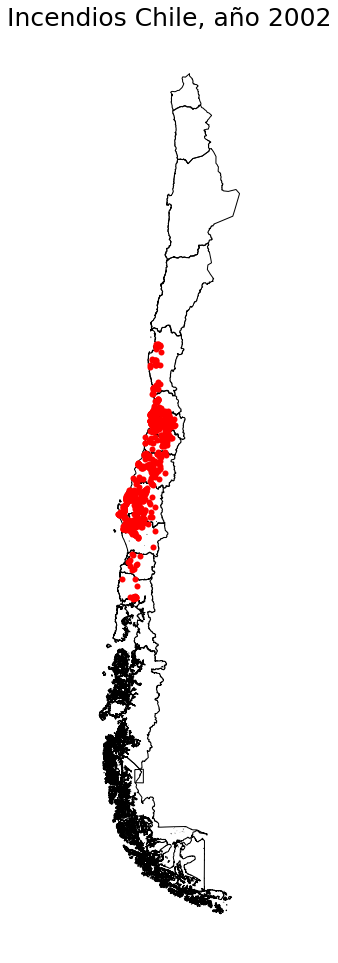

In [6]:
# Generamos gráfico 2002


fig, ax = plt.subplots(1, figsize=(15, 17))
regiones.plot(ax=ax, color = 'None' , edgecolor='k', lw = 1)
incendios_a.plot(ax = ax, color = 'red', lw = 0.01)
ax.set_title('Incendios Chile, año 2002', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

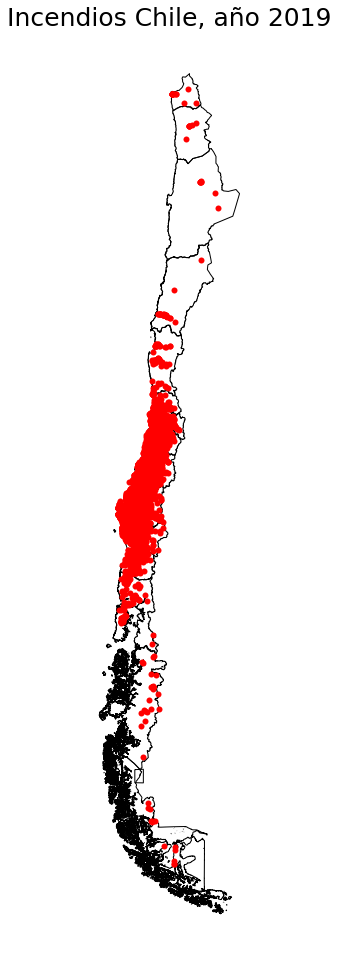

In [7]:
# Generamos gráfico 2019


fig, ax = plt.subplots(1, figsize=(15, 17))
regiones.plot(ax=ax, color = 'None' , edgecolor='k', lw = 1)
incendios_b.plot(ax = ax, color = 'red', lw = 0.01)
ax.set_title('Incendios Chile, año 2019', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

#### Se puede observar una notable diferencia en cantidades de incendios para ambos años. Para el año 2002  los incendios ocurrieron en una menor cantidad y estos fueron totalmente focalizados en zonas céntricas del país. Por otra parte, en el año 20019 se observa un notable aumento en la cantidad de incendios. Estos siguen ocurriendo en una mayor cantidad en zonas céntricas, pero a diferencia del año 2002, podemos observar que para este año sí ocurren incendios a lo largo de todo el país.

# Parte 3: Efectuamos estadísticas de densidad y distancia

In [8]:
# Generamos columnas x e y con las coordenadas de los incendios
incendios_a['x'] = incendios_a.centroid.x
incendios_a['y'] = incendios_a.centroid.y

incendios_b['x'] = incendios_b.centroid.x
incendios_b['y'] = incendios_b.centroid.y

In [9]:
# Generamos un objeto PointPattern en base a los datos (Pysal)

points_a = np.array([[x,y] for x,y in zip(incendios_a.x, incendios_a.y)])
points_b = np.array([[x,y] for x,y in zip(incendios_b.x, incendios_b.y)])

pp_a = PointPattern(points_a)
pp_b = PointPattern(points_b)

In [10]:
print('*******************************************')
print('Summary para puntos incendios en año 2002')
print('*******************************************' +  '\n')
pp_a.summary()

*******************************************
Summary para puntos incendios en año 2002
*******************************************

Point Pattern
1372 points
Bounding rectangle [(87836.16897467623,5397524.04988895), (375503.83074320643,6692497.18590896)]
Area of window: 372521894091.9372
Intensity estimate for window: 3.683005003892187e-09
               x             y
0  296501.651607  6.686487e+06
1  286494.400512  6.686514e+06
2  273507.354158  6.586500e+06
3  280489.691350  6.679496e+06
4  288499.781064  6.692497e+06


In [11]:
print('*******************************************')
print('Summary para puntos incendios en año 2019')
print('*******************************************' +  '\n')
pp_b.summary()

*******************************************
Summary para puntos incendios en año 2019
*******************************************

Point Pattern
8050 points
Bounding rectangle [(86005.88522604457,4047559.589880457), (595561.196782934,7988954.56154176)]
Area of window: 2008358742753.633
Intensity estimate for window: 4.008248042858496e-09
               x             y
0  291475.116934  6.845096e+06
1  296448.897719  6.845337e+06
2  315646.676620  6.837033e+06
3  330257.384355  6.835899e+06
4  325227.246875  6.837919e+06


## Test Chi cuadrado para datos año 2002:

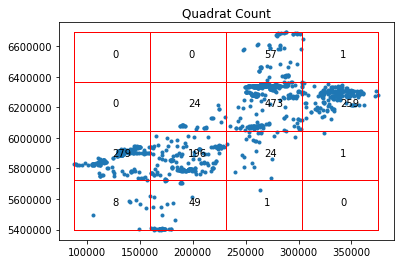

 Valor-p Test chi cuadrado: 0.0


In [12]:
csr_process = csr(pp_a.window, pp_a.n, 99, asPP=True)

#Distribucion observada de puntos
qstat = QStatistic(pp_a, shape= "rectangle",nx = 4, ny = 4, realizations = csr_process)
qstat.plot()
print(f" Valor-p Test chi cuadrado: {qstat.chi2_pvalue}")


## Test Chi cuadrado para datos año 2019:

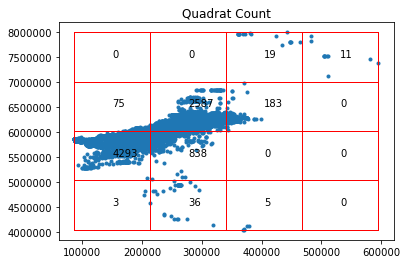

 Valor-p Test chi cuadrado: 0.0


In [13]:
csr_process = csr(pp_b.window, pp_a.n, 99, asPP=True)

#Distribucion observada de puntos
qstat = QStatistic(pp_b, shape= "rectangle",nx = 4, ny = 4, realizations = csr_process)
qstat.plot()
print(f" Valor-p Test chi cuadrado: {qstat.chi2_pvalue}")


In [14]:
## Métrica de distancia KNN:

In [15]:
# Definimos características de los datos

left_a, right_a, bottom_a, top_a = incendios_a.x.min(), incendios_a.x.max(), incendios_a.y.min(), incendios_a.y.max()
left_b, right_b, bottom_b, top_b = incendios_b.x.min(), incendios_b.x.max(), incendios_b.y.min(), incendios_b.y.max()
n_a = incendios_a.shape[0]
n_b = incendios_b.shape[0]

In [16]:
nsim = 100

ANN_a = []
ANN_b = []

for ns in range(nsim):
    x_a = np.random.uniform(left_a, right_a, (n_a, 1))
    y_a = np.random.uniform(bottom_a, top_a, (n_a, 1))
    x_b = np.random.uniform(left_b, right_b, (n_b, 1))
    y_b = np.random.uniform(bottom_b, top_b, (n_b, 1))
    
    points_rand_a = [[x[0], y[0]] for x, y in zip(x_a, y_a)]
    points_rand_b = [[x[0], y[0]] for x, y in zip(x_b, y_b)]

    pprand_a = PointPattern(points_rand_a)
    pprand_b = PointPattern(points_rand_b)
    
    ANN_a.append(pprand_a.mean_nnd)
    ANN_b.append(pprand_b.mean_nnd)

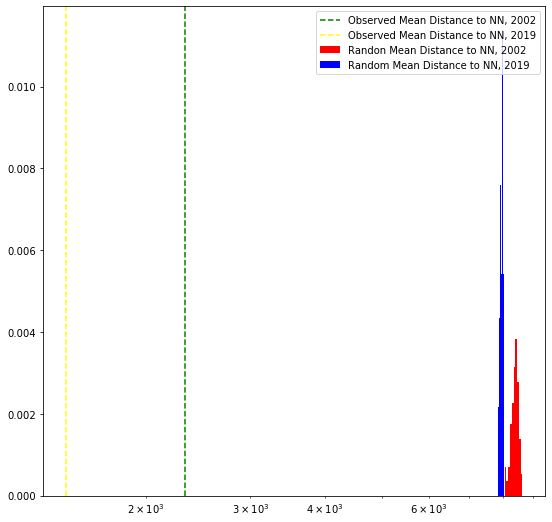

In [195]:
f, ax = plt.subplots(1, figsize=(9, 9))

ax.axvline(x = pp_a.mean_nnd,ls='--',color='green',label='Observed Mean Distance to NN, 2002')
ax.axvline(x = pp_b.mean_nnd,ls='--',color='yellow',label='Observed Mean Distance to NN, 2019')
ax.hist(ANN_a, bins=10,color='red',label='Randon Mean Distance to NN, 2002',normed=True)
ax.hist(ANN_b, bins=10,color='blue',label='Random Mean Distance to NN, 2019',normed=True)


ax.set_xscale('log')
ax.legend()
plt.show()

#### Ambos casos muestran ser datos que tienden a la clusterización, esto puede ser visto mediante el test chi cuadrado de ambos casos y también corroborado por el último gráfico. Sin embargo, no es comparable aún cuál de estos años presenta una mayor dispersión puesto que la cantidad de sucesos y el área de estos es distinta para ambas simulaciones. Para obtener una comparación objetiva podemos utilizar la tasa promedio del vecino más cercano para ambos años y comparar.

## Tasa KNN promedio:

In [17]:
print(f" Tasa KNN año 2002: {pp_a.mean_nnd/np.mean(ANN_a)}")
print(f" Tasa KNN año 2019: {pp_b.mean_nnd/np.mean(ANN_b)}")

 Tasa KNN año 2002: 0.27910687073214757
 Tasa KNN año 2019: 0.18417501600493377


#### Es decir, en el año 2019 los datos de incendios se encuentran más concentrados o clusterizados que en el año 2002. De todas formas, en ambos años los datos son clusterizados debido a que el índice es menor que 1.

# Parte 4: Identificación de Clusters

In [18]:
minp_a = np.round(incendios_a.shape[0] * 0.01) 
minp_b = np.round(incendios_b.shape[0] * 0.01)

In [19]:
def clusters(db, r, m, contorno = None):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db     : (Geo)DataFrame
             Table with at least columns `X` and `Y` for point coordinates
    r      : float
             Maximum radious to search for points within a cluster
    m      : int
             Minimum number of points in a cluster
    
    contorno: Contorno en el cual se encuentran los datos. None por defecto
    '''
    cs, lbls = dbscan(db[['x', 'y']], eps=r, min_samples=m)
    lbls = pd.Series(lbls, index=db.index)
    f, ax = plt.subplots(1, figsize=(8, 8))
    noise = db.loc[lbls==-1, ['x', 'y']]
    cores = db.loc[lbls!=-1, ['x', 'y']]

    ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
    ax.scatter(cores['x'], cores['y'],c='red', linewidth=0)
    
    if contorno is not None:
        contorno.boundary.plot(ax=ax,color='k',lw=1)

    return f, ax, lbls

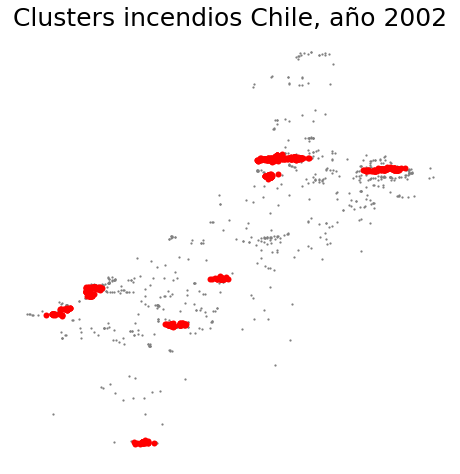

In [20]:

f, ax, lbls_a = clusters(incendios_a, 5000, minp_a)
ax.set_title('Clusters incendios Chile, año 2002', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

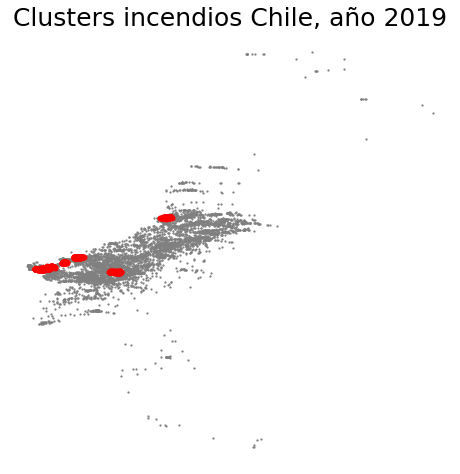

In [21]:
f, ax, lbls_b = clusters(incendios_b, 5000, minp_b)
ax.set_title('Clusters incendios Chile, año 2019', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

#### Consideramos comos clusters zonas de radio 5km tal que al menos un 1% de los datos de incendios se encuentren en dicha zona. Me pareció razonable un radio de esa magnitud considerando que las zonas en las que se estpa trabajando (todo Chile) posee magnitudes de distancia en orden de kilómetros.

## Cantidad de Clusters y ubicación

In [201]:
print(f"Cantidad de Clusters año 2002: {len(lbls_a.unique()) - 1}")
print(f"Cantidad de Clusters año 2019: {len(lbls_b.unique()) - 1}")

Cantidad de Clusters año 2002: 9
Cantidad de Clusters año 2019: 6


In [22]:
# Cruzamos tablas 

incendios_a = incendios_a.reset_index()
incendios_b = incendios_b.reset_index()

lbls_a = lbls_a.to_frame('label').reset_index()
lbls_b = lbls_b.to_frame('label').reset_index()

incendios_a = incendios_a.merge(lbls_a, left_on='index', right_on='index')
incendios_b = incendios_b.merge(lbls_b, left_on='index', right_on='index')

In [23]:
regiones = regiones.reset_index()

In [ ]:
tabla_a = gpd.overlay(regiones[['index', 'NOM_REG', 'geometry']], incendios_a[['label', 'geometry']], how = 'intersection')

In [ ]:
tabla_b = gpd.overlay(regiones[['index', 'NOM_REG', 'geometry']], incendios_b[['label', 'geometry']], how = 'intersection')

# Visualización de Clusters en el mapa de Chile

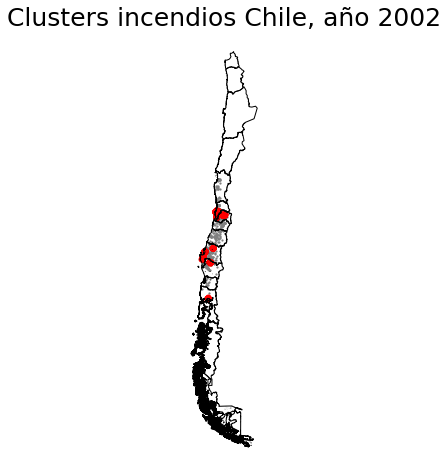

In [117]:
f, ax, lbls = clusters(incendios_a, 5000, minp_a, regiones)
ax.set_title('Clusters incendios Chile, año 2002', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

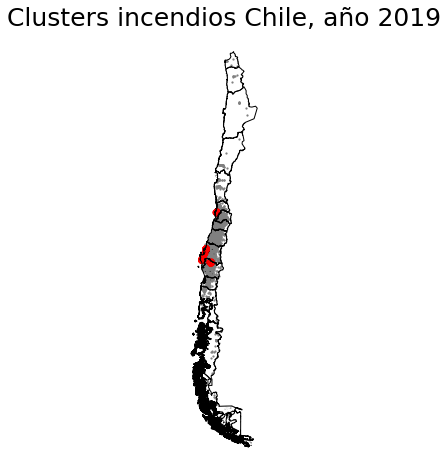

In [73]:
f, ax, lbls = clusters(incendios_b, 5000, minp_b, regiones)
ax.set_title('Clusters incendios Chile, año 2019', fontdict={'fontsize': 25, 'fontweight' :  30, 'color': 'black'})
ax.axis('off')
plt.show()

#### Se puede notar que el número de incendios durante el transcurso de los 18 años aumentó considerablemente. A partir del análisis, se puede notar que el número de clusters para el segundo caso disminuyó, sin embargo cada uno de estos contiene una mayor cantidad de datos que para el caso de los clusters de incendios del año 2002. Si bien es cierto que para el año 2019 se puede observar ocurrencia de incendios casi a lo largo de todo el país, cosa que no ocurría para el año 2002, esto no quiso decir que los patrones de datos fueran más dispersos sino que por el contrario, se focalizaron más en zonas céntricas.